In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_evaluation_data(folder_path):
    """
    Loads all Excel files starting with "Evaluation_" from a folder into pandas DataFrames,
    reading all sheets except those named "comparison".

    Args:
        folder_path (str): The path to the folder containing the Excel files.

    Returns:
        dict: A dictionary where keys are filenames (without extension) and values are
              dictionaries of DataFrames.  The inner dictionary's keys are sheet names
              and values are the corresponding DataFrames. Returns an empty dictionary
              if no matching files are found.
    """

    dataframes = {}
    for filename in os.listdir(folder_path):
        if filename.startswith("Evaluation_") and filename.endswith(".xlsx"):
            file_path = os.path.join(folder_path, filename)
            try:
                excel_file = pd.ExcelFile(file_path)
                sheet_names = excel_file.sheet_names
                
                # Create a dictionary to store DataFrames for each sheet in the file
                file_dataframes = {}
                
                for sheet_name in sheet_names:
                    try:
                        df = excel_file.parse(sheet_name)
                        file_dataframes[sheet_name] = df
                    except Exception as e:
                        print(f"Error reading sheet '{sheet_name}' from file '{filename}': {e}")
                
                # Only add to the main dictionary if we successfully read at least one sheet
                if file_dataframes:
                    # Remove the ".xlsx" extension from the filename for the key
                    file_key = filename[:-5]  
                    dataframes[file_key] = file_dataframes
                else:
                    print(f"No sheets other than 'comparison' found in file '{filename}'. Skipping.")
            
            except Exception as e:
                print(f"Error reading file '{filename}': {e}")

    return dataframes

In [3]:
folder_path = "evaluation"  # Replace with the actual path to your folder
data = load_evaluation_data(folder_path)

# Basic analysis

In [21]:
df = data["Evaluation_search"]["HyDE"][['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']]
display(df)

,correctness,faithfulness,answer_relevancy,context_relevancy,precision,recall,f1_score
0,0.000000,1.000000,0.229830,0.500000,0.047619,0.111111,0.066667
1,0.800000,0.666667,0.575930,0.437500,0.000000,0.000000,0.000000
2,0.900000,1.000000,0.437162,0.205128,0.117647,0.250000,0.160000
3,0.800000,1.000000,0.607824,0.000000,0.000000,0.000000,0.000000
4,1.000000,1.000000,0.304125,0.114286,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
143,1.000000,1.000000,0.589505,1.000000,0.156250,0.416667,0.227273
144,1.000000,1.000000,0.725561,0.305556,0.147059,0.416667,0.217391
145,1.000000,1.000000,0.663888,0.279070,0.307692,0.750000,0.436364
146,1.000000,1.000000,0.585699,0.043478,0.000000,0.000000,0.000000


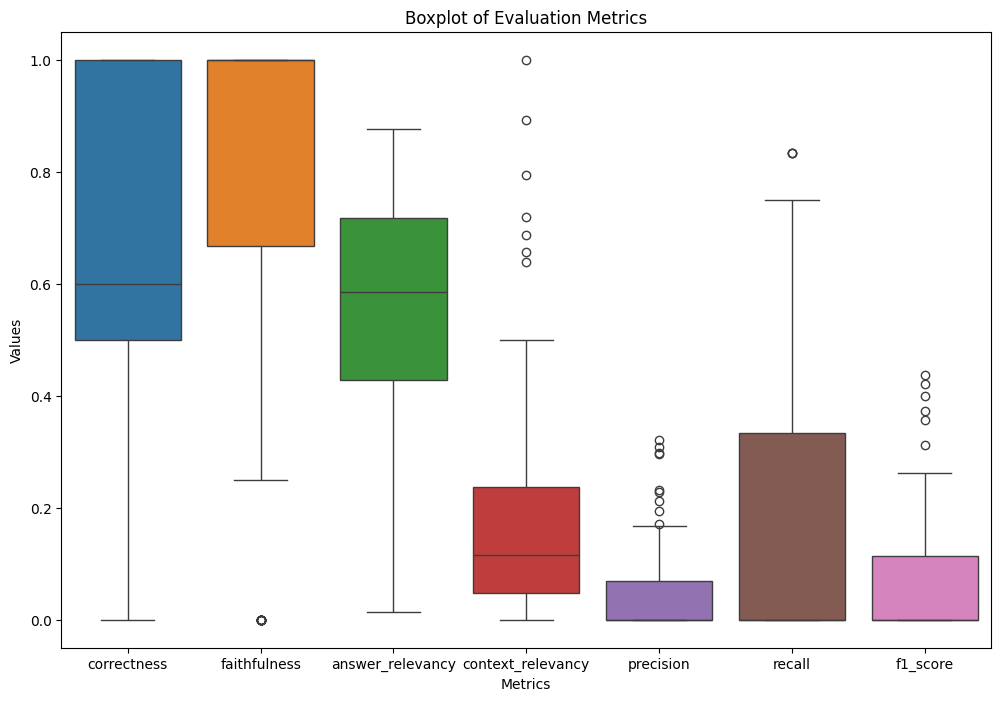

In [27]:
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(data=df)

# Set the title and labels
plt.title('Boxplot of Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Display the plot
plt.show()

# Per question analysis

In [14]:
dfs_per_question = {}
hypothesis = "rerankers"#"Graph_CoT"
for sheet in data[f"Evaluation_{hypothesis}"].keys(): # 
    if (sheet.lower() != "comparison") and (sheet.lower() == "rerank_gpt" or sheet.lower() == "basic"):
    
        df = data[f"Evaluation_{hypothesis}"][sheet].copy().dropna()
        block_size = 21  # Number of questions per company/report
        df['group_id'] = (df.index // block_size)  # Integer division to get the block number

        df['question_order'] = df.groupby('group_id')['question'].transform(lambda x: x.astype('category').cat.reorder_categories(x.unique(), ordered=True).cat.codes)

        dfs_per_question[sheet] = df.groupby('question', as_index=False)[['correctness', 'faithfulness', 'answer_relevancy',
                                                        'context_relevancy', 'precision', 'recall', 'f1_score']].mean()

        dfs_per_question[sheet] = pd.merge(dfs_per_question[sheet], df[['question', 'question_order']].drop_duplicates(subset=['question']), on='question', how='left')

        dfs_per_question[sheet] = dfs_per_question[sheet].sort_values(by='question_order')

        dfs_per_question[sheet] = dfs_per_question[sheet].drop(['group_id', 'question_order'], axis=1, errors='ignore')


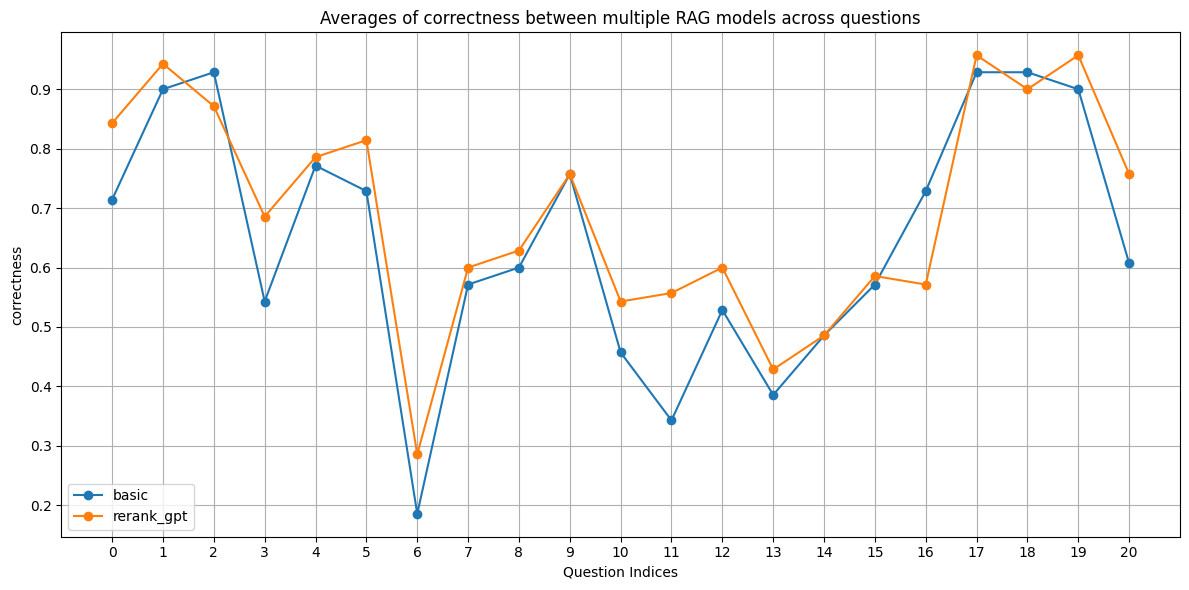

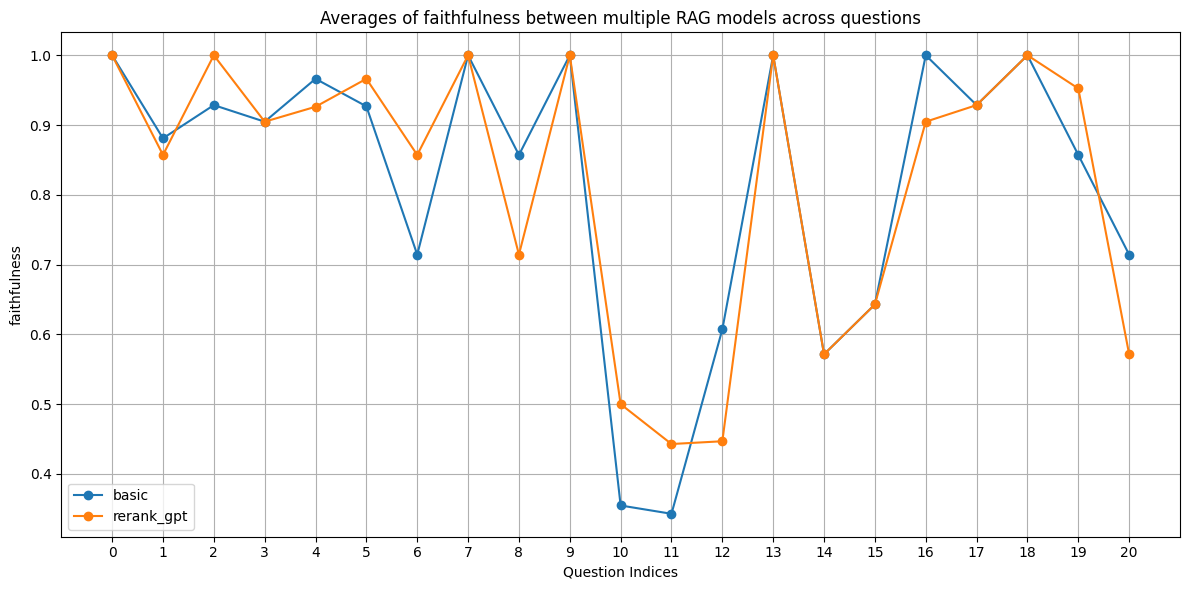

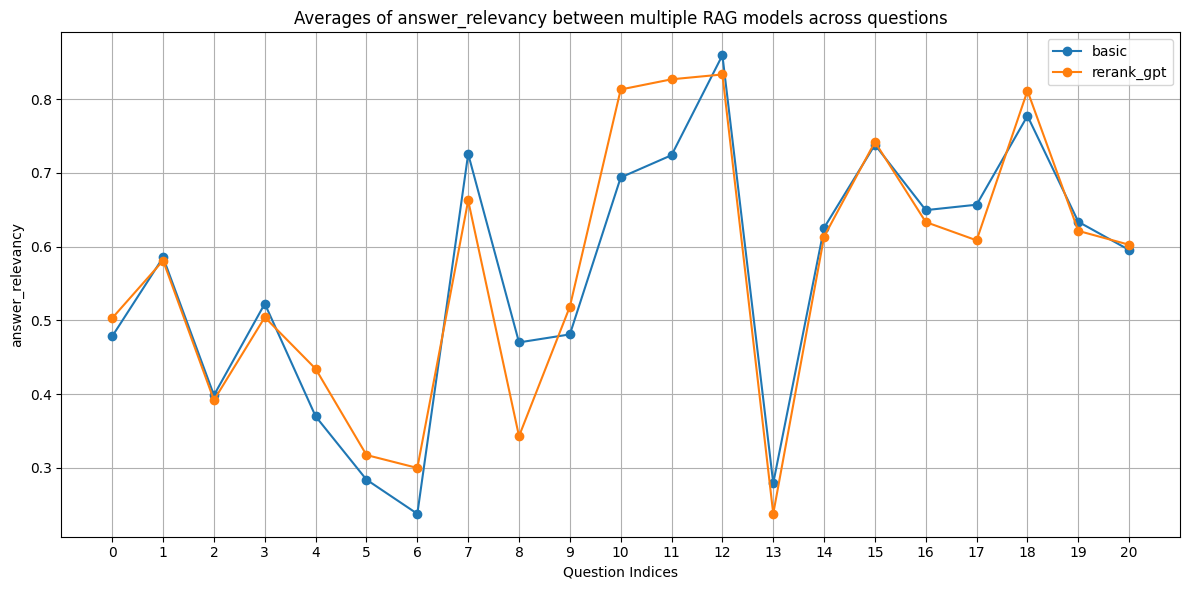

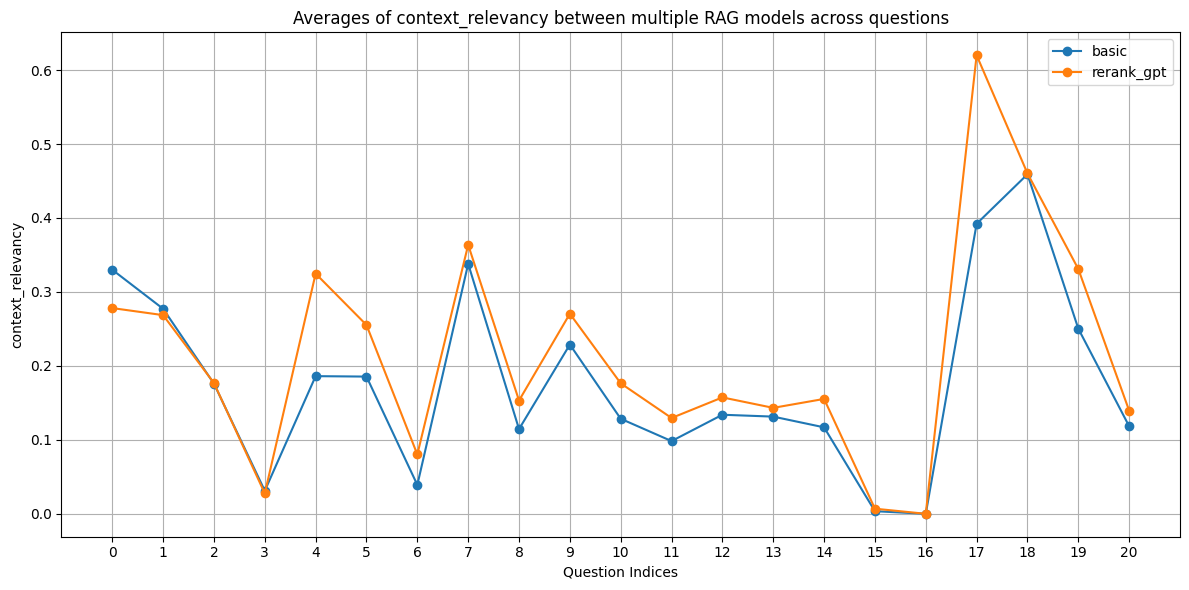

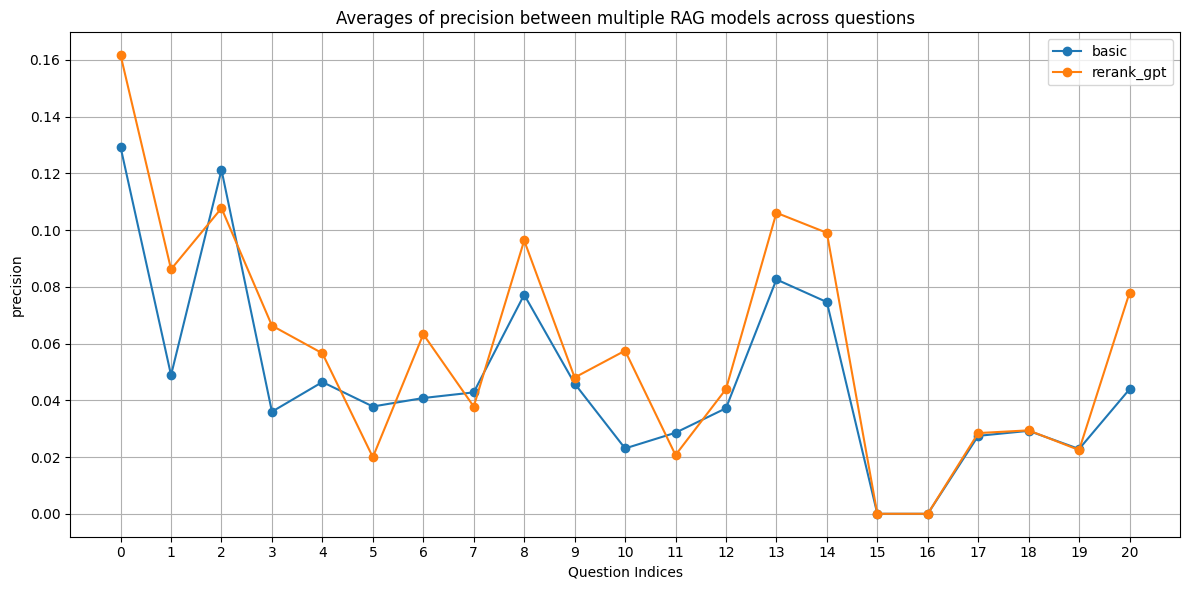

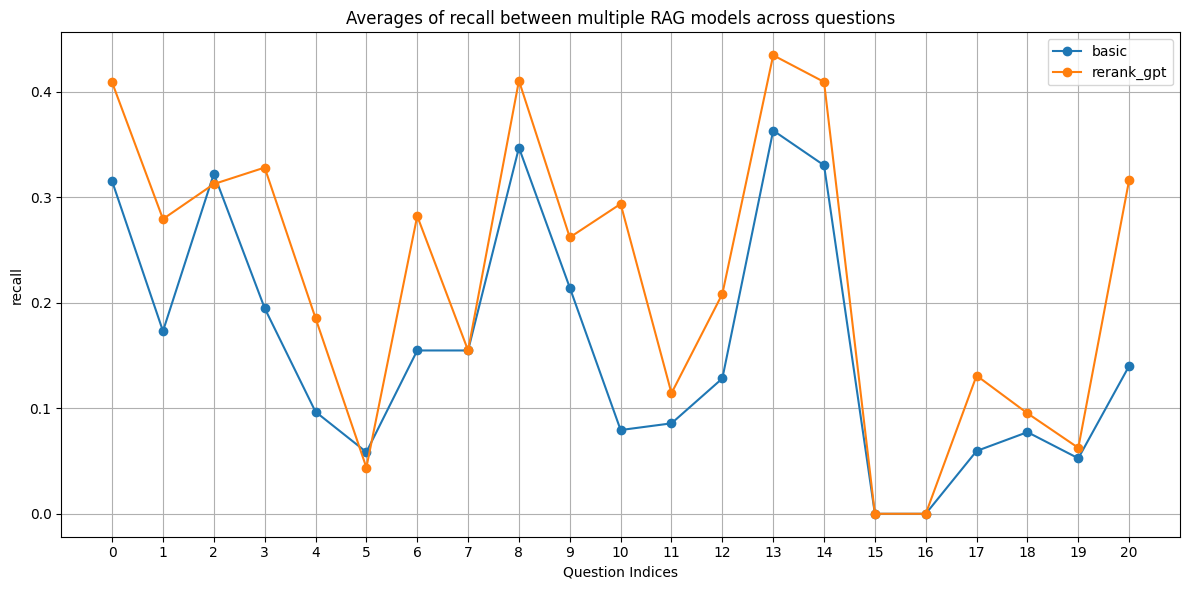

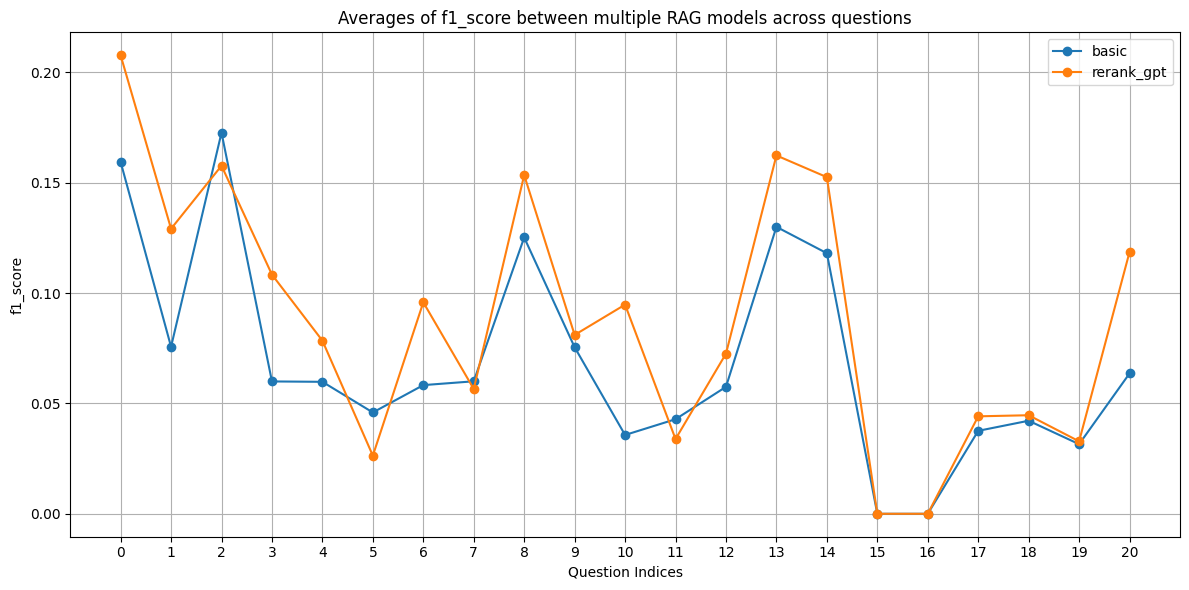

In [15]:
metrics = ['correctness', 'faithfulness', 'answer_relevancy', 'context_relevancy', 'precision', 'recall', 'f1_score']

questions = []
for sheet, df in dfs_per_question.items():
    if not questions:  # Take questions from the first DataFrame only
        questions = df['question'].tolist()  # Get the 'question' column as a list

indices = range(len(questions))

for metric in metrics:
    plt.figure(figsize=(12, 6))

    for sheet, df in dfs_per_question.items():
        if metric in df.columns:
            # Create a mapping from question to metric value, handling missing questions
            metric_values = []
            for question in questions:
                if question in df['question'].values:
                    metric_values.append(df[df['question'] == question][metric].values[0])
                else:
                    metric_values.append(None)  # Or np.nan if you prefer

            # Plot the metric values
            plt.plot(indices, metric_values, marker='o', label=sheet)

    plt.title(f'Averages of {metric} between multiple RAG models across questions')
    plt.xlabel('Question Indices')
    plt.ylabel(metric)
    plt.xticks(ticks=indices)    
    plt.tight_layout()  
    plt.legend()
    plt.grid(True)
    plt.show()

# Average of metrics analysis

\begin{tabular}{lrrrrrrr}
\toprule
sheet_name & correctness & faithfulness & answer_relevancy & context_relevancy & precision & recall & f1_score \\
\midrule
KG-rerankGPT-8 & 0.7277 & 0.8298 & 0.5642 & 0.0472 & 0.0180 & 0.2650 & 0.0328 \\
KG-8 & 0.7202 & 0.8218 & 0.5683 & 0.0391 & 0.0156 & 0.3152 & 0.0288 \\
\bottomrule
\end{tabular}



,sheet_name,correctness,faithfulness,answer_relevancy,context_relevancy,precision,recall,f1_score
0,KG-rerankGPT-8,0.7277,0.8298,0.5642,0.0472,0.0180,0.2650,0.0328
0,KG-8,0.7202,0.8218,0.5683,0.0391,0.0156,0.3152,0.0288


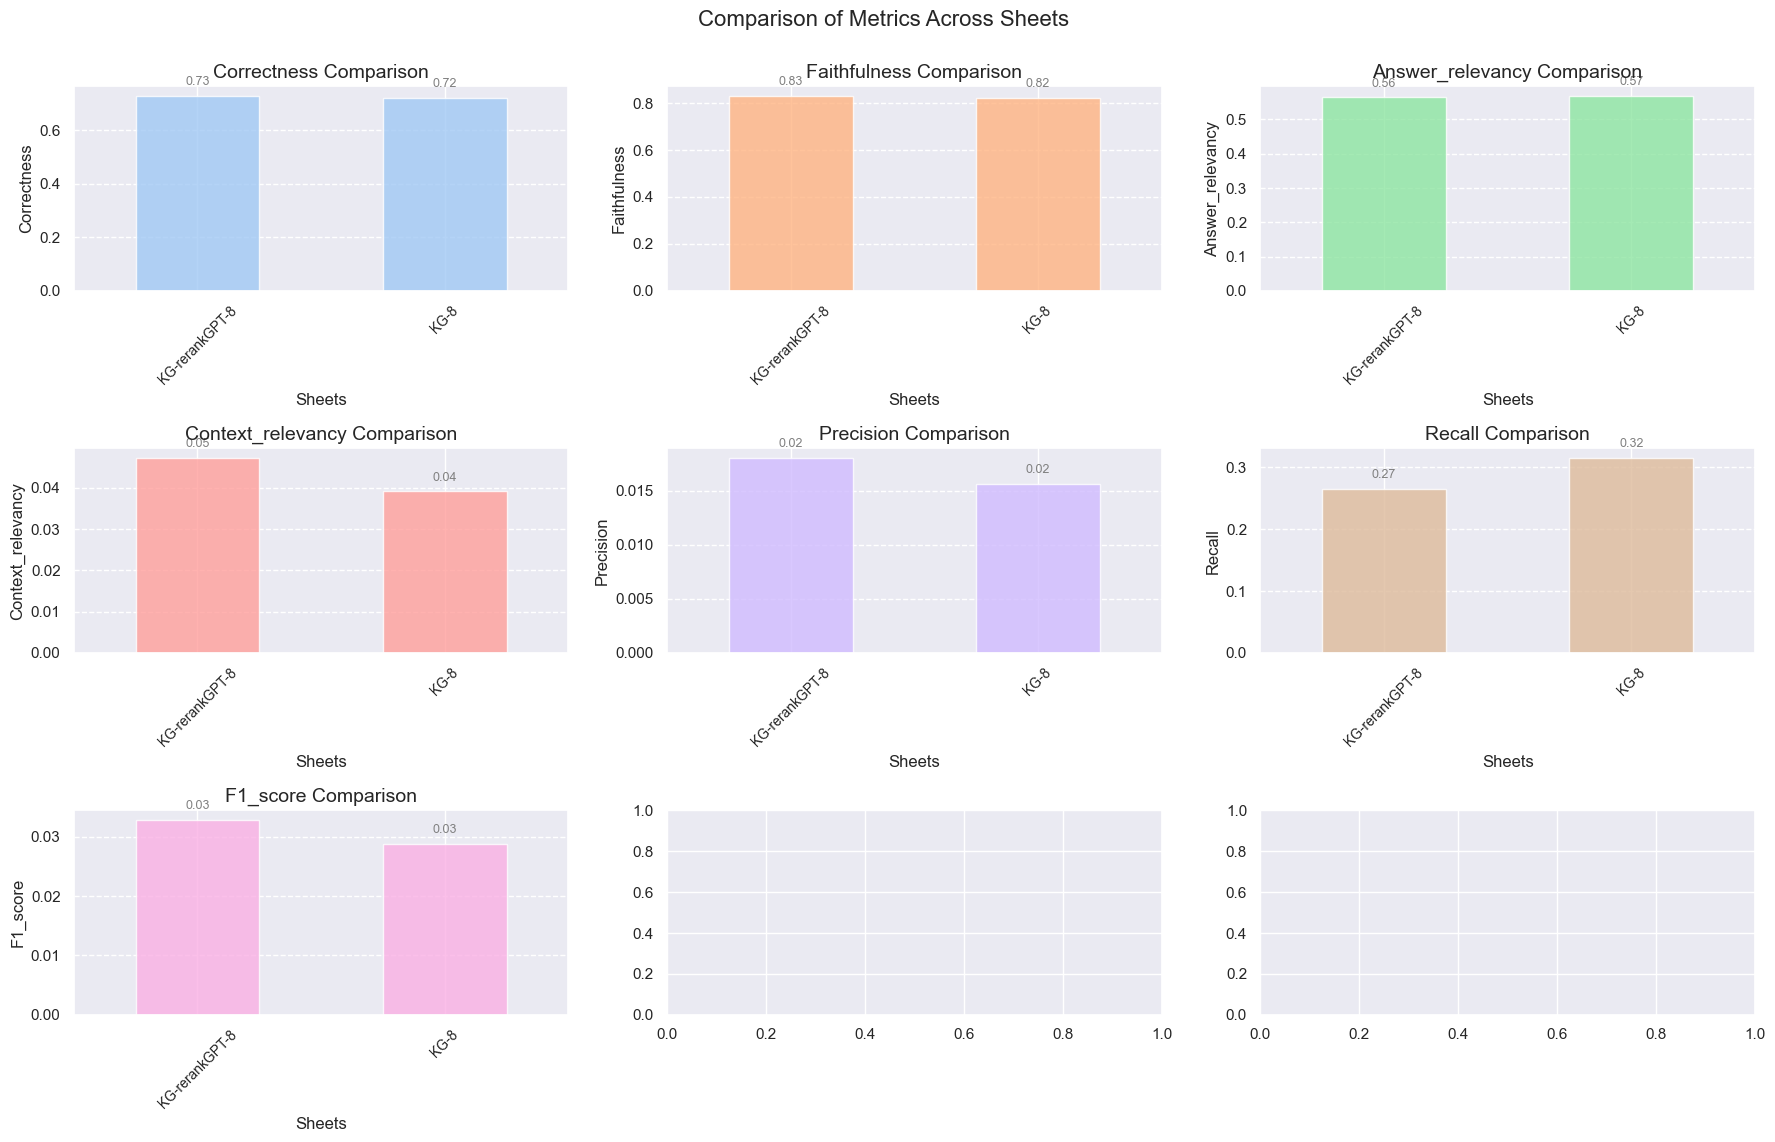

In [78]:
comparison_df = pd.DataFrame()
hypothesis = "interactions_KG_rerankGPT"
for sheet_name in data[f"Evaluation_{hypothesis}"].keys():
    if sheet_name.lower() != "comparison":
        row = data[f"Evaluation_{hypothesis}"][sheet_name][['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']].mean().to_frame().T
        row.insert(0, 'sheet_name', sheet_name)  # Insert 'sheet_name' at the beginning
        comparison_df = pd.concat([comparison_df, row], axis=0)

numeric_cols = comparison_df.columns.drop('sheet_name') # Get list of numeric columns
comparison_df[numeric_cols] = comparison_df[numeric_cols].round(4)
latex = comparison_df.to_latex(float_format="%.4f", index=False)
print(latex)
display(comparison_df)
comparison_df.set_index('sheet_name', inplace=True)

# --- Improved Visuals ---
# Use a more visually appealing style (optional)
sns.set(style="darkgrid")  # Options: "whitegrid", "darkgrid", "white", "ticks"

# Define a color palette
colors = sns.color_palette("pastel")  # Options: "muted", "bright", "deep"

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Slightly larger figure
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, metric in enumerate(comparison_df.columns):
    comparison_df[metric].plot(
        kind='bar',
        ax=axes[i],
        color=colors[i % len(colors)],  # Cycle through colors
        alpha=0.8,  # Add some transparency
    )
    axes[i].set_title(f'{metric.capitalize()} Comparison', fontsize=14)  # Larger title
    axes[i].set_xlabel('Sheets', fontsize=12)  # Larger label
    axes[i].set_ylabel(metric.capitalize(), fontsize=12)  # Larger label
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels
    axes[i].grid(axis='y', linestyle='--')  # Add a subtle grid

    # Add value labels on top of bars (optional)
    for p in axes[i].patches:
        axes[i].annotate(
            f"{p.get_height():.2f}",  # Format the value
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=9,
            color='gray'
        )

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Add space for a title

# Add a figure-level title
fig.suptitle('Comparison of Metrics Across Sheets', fontsize=16)

# Display the plot
plt.show()

# Token usage


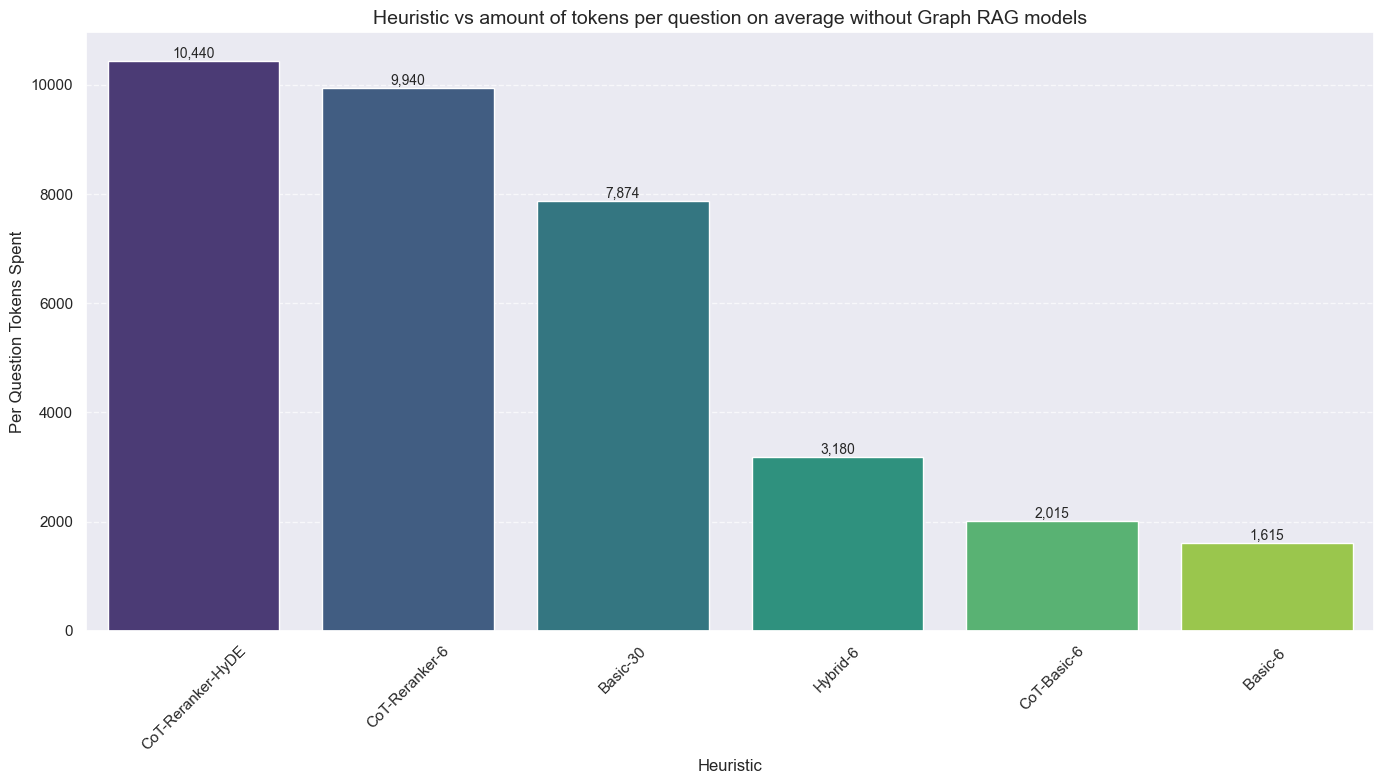

In [93]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

df_tokens = pd.read_excel("evaluation/Token_usage.xlsx", sheet_name="tokens_spent")
df_filtered = df_tokens[~df_tokens["Heuristic"].str.contains("KG")]

# Sort df_filtered token usage for clearer visibility
df_filtered = df_filtered.sort_values("per question", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    x="Heuristic", 
    y="per question", 
    data=df_filtered, 
    hue="Heuristic", 
    dodge=False, 
    palette="viridis",
    legend=False
)

# Add value labels
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{int(height):,}', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', fontsize=10)

plt.title("Heuristic vs amount of tokens per question on average without Graph RAG models", fontsize=14)
plt.xlabel("Heuristic", fontsize=12)
plt.ylabel("Per Question Tokens Spent", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# # Static graph for 'per_report'
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Heuristic', y='per report', data=df_filtered, palette='viridis')
# plt.title('Heuristic vs Per Report')
# plt.xlabel('Heuristic')
# plt.ylabel('Per Report')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Statistical significance


In [45]:
df1 = data["Evaluation_chunking"]["enriched"]
df2 = data["Evaluation_CoT"]["CoT"]
#df2 = data["Evaluation_rerankers"]["cross_encoder"]
number_of_records = df1.shape[0]


In [46]:
from scipy import stats
import numpy as np

# Assuming df1 and df2 have the same columns
metrics = ['correctness', 'faithfulness', 'answer_relevancy',
           'context_relevancy', 'precision', 'recall', 'f1_score']

# Perform the Kolmogorov-Smirnov test for normality for each metric in df1 and df2
results_df1 = {}
results_df2 = {}

for metric in metrics:
    # Generate a normal distribution with the same mean and standard deviation as the sample
    mean_df1, std_df1 = np.mean(df1[metric]), np.std(df1[metric])
    mean_df2, std_df2 = np.mean(df2[metric]), np.std(df2[metric])

    # Perform the K-S test
    stat_df1, p_value_df1 = stats.kstest(df1[metric], 'norm', args=(mean_df1, std_df1))
    stat_df2, p_value_df2 = stats.kstest(df2[metric], 'norm', args=(mean_df2, std_df2))

    results_df1[metric] = {'statistic': stat_df1, 'p_value': p_value_df1}
    results_df2[metric] = {'statistic': stat_df2, 'p_value': p_value_df2}

# Print the results for df1
print("Normality test results for df1:")
for metric, result in results_df1.items():
    print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

# Print the results for df2
print("\nNormality test results for df2:")
for metric, result in results_df2.items():
    print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

# Determine if the data is normally distributed
alpha = 0.05
normality_df1 = {metric: result['p_value'] > alpha for metric, result in results_df1.items()}
normality_df2 = {metric: result['p_value'] > alpha for metric, result in results_df2.items()}

print("\nData is normally distributed in df1:\n", normality_df1)
print("\nData is normally distributed in df2:\n", normality_df2)

Normality test results for df1:
correctness - Statistic: 0.16981923468938265, p-value: 0.000355599632214318
faithfulness - Statistic: 0.4340634439374182, p-value: 1.065831949389036e-25
answer_relevancy - Statistic: 0.06858069063724825, p-value: 0.4731244341364301
context_relevancy - Statistic: 0.17251115077723067, p-value: 0.00026984423577131473
precision - Statistic: 0.3765745133443694, p-value: 3.104242995854702e-19
recall - Statistic: 0.38855932405017535, p-value: 1.7089492002298485e-20
f1_score - Statistic: 0.3877390443223988, p-value: 2.0910701091080676e-20

Normality test results for df2:
correctness - Statistic: 0.20514669681450348, p-value: 6.671994535165511e-06
faithfulness - Statistic: 0.38602567095760704, p-value: 3.1822556215525655e-20
answer_relevancy - Statistic: 0.07421537020530772, p-value: 0.37462815543457473
context_relevancy - Statistic: 0.17245066902213962, p-value: 0.00027153574559001084
precision - Statistic: 0.37649643601878285, p-value: 3.1623531533236045e-19
re

In [44]:
from scipy import stats

# Assuming df1 and df2 have the same columns
metrics = ['correctness', 'faithfulness', 'answer_relevancy']
        #    'context_relevancy', 'precision', 'recall', 'f1_score']

# Perform the Wilcoxon signed-rank test for each metric with alternative hypothesis "greater"
results = {}
for metric in metrics:
    # Note: We use 'less' because we want to test if df1 values are significantly smaller than df2 values
    statistic, p_value = stats.wilcoxon(df1[metric], df2[metric], alternative='less')
    results[metric] = {'statistic': statistic, 'p_value': p_value}

# Print the results
for metric, result in results.items():
    print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

alpha = 0.05
reject_null_hypothesis = {metric: result['p_value'] < alpha for metric, result in results.items()}

print("Reject null hypothesis:\n", reject_null_hypothesis)

correctness - Statistic: 902.0, p-value: 0.022831773003226252
faithfulness - Statistic: 901.5, p-value: 0.6394519623503043
answer_relevancy - Statistic: 6091.0, p-value: 0.9713045661667558
Reject null hypothesis:
 {'correctness': True, 'faithfulness': False, 'answer_relevancy': False}


In [41]:
import math
df1_averages = df1[['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']].mean()
df2_averages = df2[['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']].mean()

df1_std  = df1[['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']].std()
df2_std  = df2[['correctness', 'faithfulness', 'answer_relevancy',
                                                    'context_relevancy', 'precision', 'recall', 'f1_score']].std()
df_differences = df2_averages - df1_averages

standart_errors = (df1_std/number_of_records + df2_std/number_of_records).apply(math.sqrt)
df_differences

correctness          0.038231
faithfulness        -0.012810
answer_relevancy    -0.030550
context_relevancy    0.004519
precision           -0.000172
recall               0.000000
f1_score            -0.000180
dtype: float64

In [4]:
import numpy as np
from scipy import stats

def compare_dataframes(df1, df2, metrics = ['correctness', 'faithfulness', 'answer_relevancy',
               'context_relevancy', 'precision', 'recall', 'f1_score']):


    results_df1 = {}
    results_df2 = {}

    for metric in metrics:
        mean_df1, std_df1 = np.mean(df1[metric]), np.std(df1[metric])
        mean_df2, std_df2 = np.mean(df2[metric]), np.std(df2[metric])

        stat_df1, p_value_df1 = stats.kstest(df1[metric], 'norm', args=(mean_df1, std_df1))
        stat_df2, p_value_df2 = stats.kstest(df2[metric], 'norm', args=(mean_df2, std_df2))

        results_df1[metric] = {'statistic': stat_df1, 'p_value': p_value_df1}
        results_df2[metric] = {'statistic': stat_df2, 'p_value': p_value_df2}

    print("Normality test results for df1:")
    for metric, result in results_df1.items():
        print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

    print("\nNormality test results for df2:")
    for metric, result in results_df2.items():
        print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

    alpha = 0.05/len(metrics)
    normality_df1 = {metric: result['p_value'] > alpha for metric, result in results_df1.items()}
    normality_df2 = {metric: result['p_value'] > alpha for metric, result in results_df2.items()}

    print("\nData is normally distributed in df1:\n", normality_df1)
    print("\nData is normally distributed in df2:\n", normality_df2)

    wilcoxon_results = {}
    for metric in metrics:
        if sum(df1[metric]) != sum(df2[metric]):
            statistic, p_value = stats.wilcoxon(df1[metric], df2[metric], alternative='less')    
            wilcoxon_results[metric] = {'statistic': statistic, 'p_value': p_value}
    

    print("\nWilcoxon signed-rank test results:")
    for metric, result in wilcoxon_results.items():
        print(f"{metric} - Statistic: {result['statistic']}, p-value: {result['p_value']}")

    reject_null_hypothesis = {metric: result['p_value'] < alpha for metric, result in wilcoxon_results.items()}
    print("\nReject null hypothesis:\n", reject_null_hypothesis)



In [7]:
df1 = data["Evaluation_interactions_CoT_rerankGPT_HyDE"]["CoT_HyDE_rerankGPT-6"]
df2 = data["Evaluation_KGs"]["graph_basic_8"]

metrics = ['correctness']
compare_dataframes(df1, df2)

Normality test results for df1:
correctness - Statistic: 0.23065702845354852, p-value: 2.3336622091217968e-07
faithfulness - Statistic: 0.41219962748571637, p-value: 4.1090583689761194e-23
answer_relevancy - Statistic: 0.06508409989387848, p-value: 0.540193927852608
context_relevancy - Statistic: 0.1430429887742079, p-value: 0.004353251706968587
precision - Statistic: 0.252416789934735, p-value: 9.656544884487075e-09
recall - Statistic: 0.2815378218082729, p-value: 8.447937445641937e-11
f1_score - Statistic: 0.2631726011667989, p-value: 1.7884886679867468e-09

Normality test results for df2:
correctness - Statistic: 0.18457931363663954, p-value: 7.415328081022707e-05
faithfulness - Statistic: 0.3999115192661141, p-value: 9.946997134165664e-22
answer_relevancy - Statistic: 0.055741426481039635, p-value: 0.729463563702803
context_relevancy - Statistic: 0.10480876807566214, p-value: 0.07356947317454332
precision - Statistic: 0.21642071296242338, p-value: 1.594195380322562e-06
recall - Sta